<font size="6">*Predictive Modeling of Heart Failure using 11 Predictors*<font size="6">

***Introduction-***
Cardiovascular diseases causes 31% of mortality rate globally, with heart failure as one of the leading cause of premature deaths. For individuals associated with such life threatening diseases, early detection becomes vital for improving quality of life, reducing medical expense and providing better treatment options. 

***Predictive Question-***
Can age, resting blood pressure, maximum heart rate, and cholesterol levels accurately predict whether an individual has heart failure or not?

Early detection could improve effectiveness of treatment, thus lowering mortality and bettering global health. 

The data set we are using is called  “Heart Failure Prediction”(https://www.kaggle.com/fedesoriano/heart-failure-prediction ) from Kaggle which incorporates demographic, clinical, and laboratory data. Features like Age, Sex, ChestPain type, restingBP, Cholesterol, Maximum heart rate etc (mentioned in the link) will be explored. 

In [1]:
install.packages("gridExtra")
install.packages("kknn")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
library(RColorBrewer)
options(repr.matrix.mas.rows=5)
# install.packages("gridExtra")
library(gridExtra)
# install.packages("kknn")
library(kknn)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

### <font size="6">Preliminary Exploratory Data Analysis<font size="6">
    
**Data Retrieval/wrangling and cleaning:** We used the URL from kaggle to read our data into R and and convert into a tidy format. Fasting blood sugar is excluded from our data table because the values in that column are displayed as 0 in the dataset provided. 


In [3]:
url<-"https://raw.githubusercontent.com/Muskandavee/PROPOSAL-/main/heart.csv?token=GHSAT0AAAAAACIL7C5ONUF7EQO6NRJV2VSKZJ4MAEQ"

In [4]:
#download.file(url, "data/heart.csv")
heart_disease_data<-read_csv(url)|>
    mutate(HeartDisease=as_factor(HeartDisease))|>
    rename(ST_depression=Oldpeak)|>
    mutate(HeartDisease=ifelse(HeartDisease==1, "Yes", "No"))|>
    select(-FastingBS)

heart_disease_slice<-heart_disease_data|>
slice(1:5)
heart_disease_slice

Rows: 918 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Sex, ChestPainType, RestingECG, ExerciseAngina, ST_Slope
dbl (7): Age, RestingBP, Cholesterol, FastingBS, MaxHR, Oldpeak, HeartDisease

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Age Sex ChestPainType RestingBP Cholesterol RestingECG MaxHR ExerciseAngina
1 40  M   ATA           140       289         Normal     172   N             
2 49  F   NAP           160       180         Normal     156   N             
3 37  M   ATA           130       283         ST          98   N             
4 48  F   ASY           138       214         Normal     108   Y             
5 54  M   NAP           150       195         Normal     122   N             
  ST_depression ST_Slope HeartDisease
1 0.0           Up       No          
2 1.0           Flat     Yes         
3 0.0           Up       No          
4 1.5           Flat     Yes         
5 0.0           Up       No

<font size="4">**Splitting data into training and testing set:**<font size="4">

In [5]:
set.seed(1234)
heart_disease_split <- initial_split(heart_disease_data, prop = 0.75, strata = HeartDisease)
heart_disease_train <- training(heart_disease_split)
heart_disease_test <- testing(heart_disease_split)

heart_disease_slice_train<-heart_disease_train |>
slice(1:5)
heart_disease_slice_train

Age Sex ChestPainType RestingBP Cholesterol RestingECG MaxHR ExerciseAngina
1 37  M   ATA           130       283         ST          98   N             
2 39  M   NAP           120       339         Normal     170   N             
3 54  M   ATA           110       208         Normal     142   N             
4 48  F   ATA           120       284         Normal     120   N             
5 42  F   NAP           115       211         ST         137   N             
  ST_depression ST_Slope HeartDisease
1 0             Up       No          
2 0             Up       No          
3 0             Up       No          
4 0             Up       No          
5 0             Up       No

<font size="4"> **Exploratory data analysis in tabular formats**<font size="4"> 

We created a summary table that gives us the number of observations in each category for the variable "Sex", grouped by the presence or absence of heart disease. We can see that a higher proportion of males (approx. 64%) have a heart disease compared to women (approx. 27%) , this tells us that age can be a good variable to use in classification. We also created the same count table for ChestPainType and found that maybe ASY type of chest pain could be an indicator of heart disease.
    
We will further confirm whether these variables would be good predictors through data visualisation.


In [6]:
num_missing_rows <- sum(!complete.cases(heart_disease_train))
cat("The number of rows with missing data is", num_missing_rows, "\n")

summary_table_categorical <-  heart_disease_train %>%
  group_by(HeartDisease, Sex) %>%
  summarise(
    Count = n() )
summary_table_categorical
sex_count <- table(heart_disease_train$Sex)
sex_count
summary_table_categorical2 <-  heart_disease_train %>%
  group_by(HeartDisease, ChestPainType) %>%
  summarise(
    Count = n() )
summary_table_categorical2

num_obs <- nrow(heart_disease_train)
heart_disease_train |>
  group_by(HeartDisease) |>
  summarize( count = n(),
    percentage = n() / num_obs * 100)



The number of rows with missing data is 0 


`summarise()` has grouped output by 'HeartDisease'. You can override using the
`.groups` argument.


HeartDisease Sex Count
1 No           F   107  
2 No           M   200  
3 Yes          F    39  
4 Yes          M   342


  F   M 
146 542 

`summarise()` has grouped output by 'HeartDisease'. You can override using the
`.groups` argument.


HeartDisease ChestPainType Count
1 No           ASY            72  
2 No           ATA           114  
3 No           NAP           100  
4 No           TA             21  
5 Yes          ASY           291  
6 Yes          ATA            17  
7 Yes          NAP            56  
8 Yes          TA             17

HeartDisease count percentage
1 No           307   44.62209  
2 Yes          381   55.37791

Next, we have created a correlation matrix that shows if there is a possible relationship between the numeric variables in our data set. This table helps identify patterns in the distribution of categorical variables across different classes. For instance, it reveals that there is no significant relationship between any of the numeric variables. It also tells us that the scatterplots will show no relationship, which avoids the problem of multicollinearity. Multicollinearity results in reduced interpretability of the model, as it becomes challenging to pin-point the unique contribution of each variable.

In [7]:
correlation_matrix <- cor(heart_disease_train[, c("Age", "RestingBP", "Cholesterol", "MaxHR")])
correlation_matrix

Age         RestingBP   Cholesterol MaxHR      
Age          1.00000000  0.25059301 -0.07356863 -0.36087394
RestingBP    0.25059301  1.00000000  0.13246082 -0.09967915
Cholesterol -0.07356863  0.13246082  1.00000000  0.23033507
MaxHR       -0.36087394 -0.09967915  0.23033507  1.00000000

<font size="4">**Data Analysis Approach : Methods**<font size="4">
    
We have decided to use classification in order to answer our predictive question as we are looking to find a predicted group ("yes" or "no) and not a value. Hence we will not use regression.

  **STEPS:**
    
**Picking variables-**
   ChestPainType, Age, Sex, ExerciseAngina, and ST slope show the most effect on heart disease according to our visualizations below.
    
**Scaling data-**
    Standardize the selected predictor variables. k-NN is distance-based, so scaling the variables to have a similar range is crucial in order to avoid skewed results.

**Select k Value-**
    Determine the optimal value for the k parameter (number of neighbors to consider. We plan to use an odd number since we have 4 variables.

**Visualizing classification results-**
    We plan to visualise our data using a scatter plot. The reasons we chose scatter plots are to easily identify patterns, outliers,  and know insights about the data distribution. We will be using standardised data for the same. To check the accuracy of the classifier, confusion matrix will be implemented as it provides a concise and clear evaluation of for instance accuracy of of how the model is performing. Metrics such as precision and recall in the confusion matrix, allow further assembly of the model.
Threshold Tunning and F1 score will also aid in effective prediction of the model.
    

    

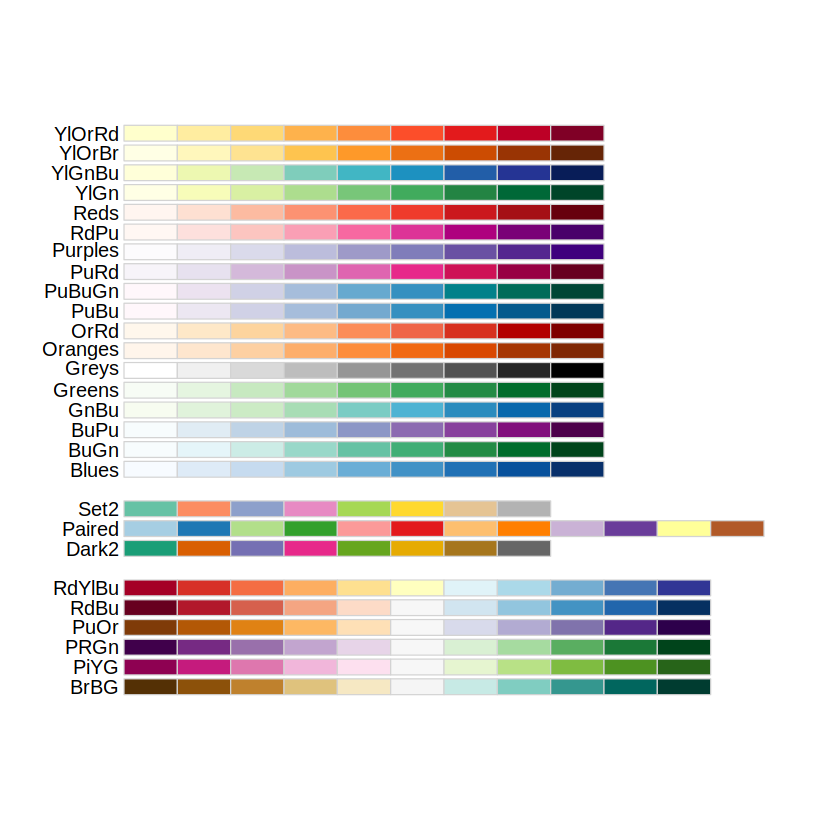

In [8]:
display.brewer.all(colorblindFriendly = TRUE)

<font size="4">**DATA VISUALISATION OF TRAINING DATA**<font size="4">
    
We explored the relationship between some of the predictors and heart disease. 


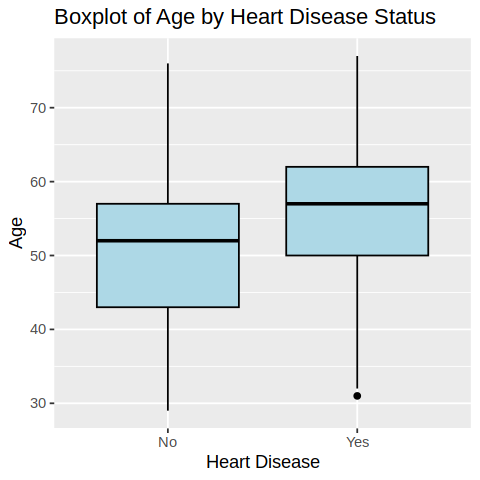

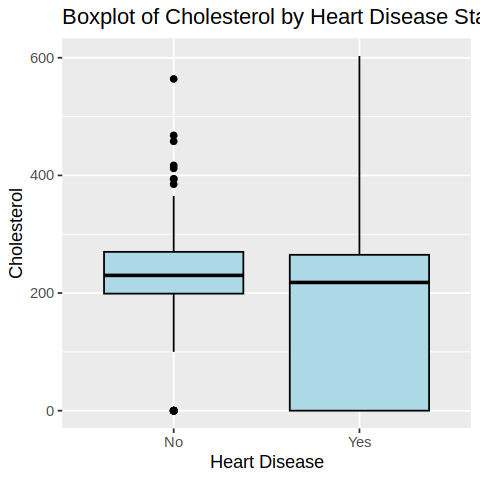

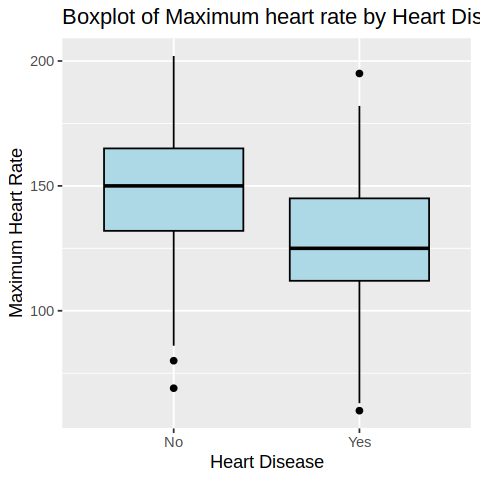

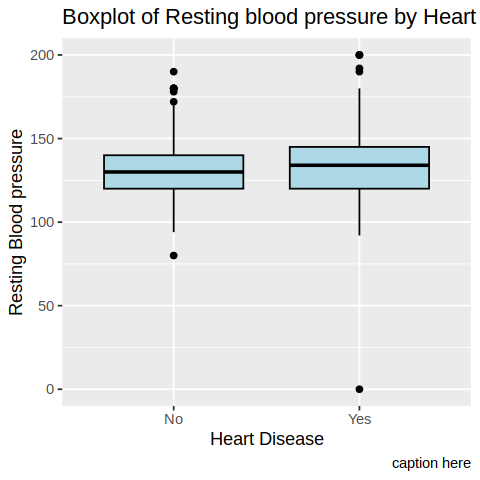

In [9]:
options(repr.plot.width = 4, repr.plot.height = 4)
Age_boxplot <- ggplot(heart_disease_train, aes(x = HeartDisease, y = Age)) +
  geom_boxplot(fill = "lightblue", color = "black") +
  labs(title = "Boxplot of Age by Heart Disease Status",
       x = "Heart Disease",
       y = "Age")
Age_boxplot 
Cholesterol_boxplot <- ggplot(heart_disease_train, aes(x = HeartDisease, y = Cholesterol)) +
  geom_boxplot(fill = "lightblue", color = "black") +
  labs(title = "Boxplot of Cholesterol by Heart Disease Status",
       x = "Heart Disease",
       y = "Cholesterol")
Cholesterol_boxplot
MaxHR_boxplot <- ggplot(heart_disease_train, aes(x = HeartDisease, y = MaxHR)) +
  geom_boxplot(fill = "lightblue", color = "black") +
  labs(title = "Boxplot of Maximum heart rate by Heart Disease Status",
       x = "Heart Disease",
       y = "Maximum Heart Rate")
MaxHR_boxplot
RestingBP_boxplot <- ggplot(heart_disease_train, aes(x = HeartDisease, y = RestingBP)) +
  geom_boxplot(fill = "lightblue", color = "black") +
  labs(title = "Boxplot of Resting blood pressure by Heart Disease Status",
       x = "Heart Disease",
       y = "Resting Blood pressure",
      caption = "caption here")
RestingBP_boxplot




Based on these boxplots..............

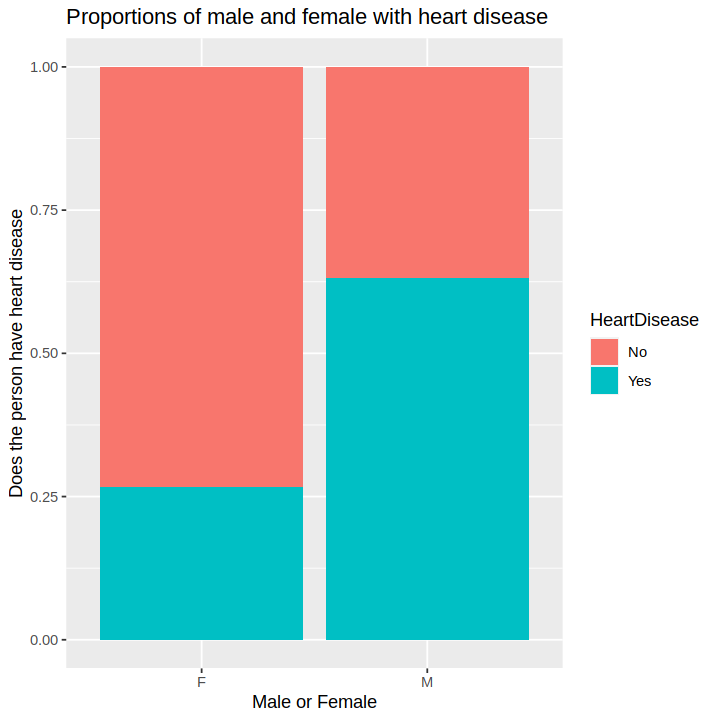

In [10]:
options(repr.plot.width = 6, repr.plot.height = 6)
sex_plot<-heart_disease_train|>
ggplot(aes(x=Sex, fill=HeartDisease))+
geom_bar(position="fill")+
xlab("Male or Female")+
ylab("Does the person have heart disease")+
labs("Heart Disease")+
ggtitle("Proportions of male and female with heart disease")+
scale_color_brewer(palette = "Set2")
sex_plot

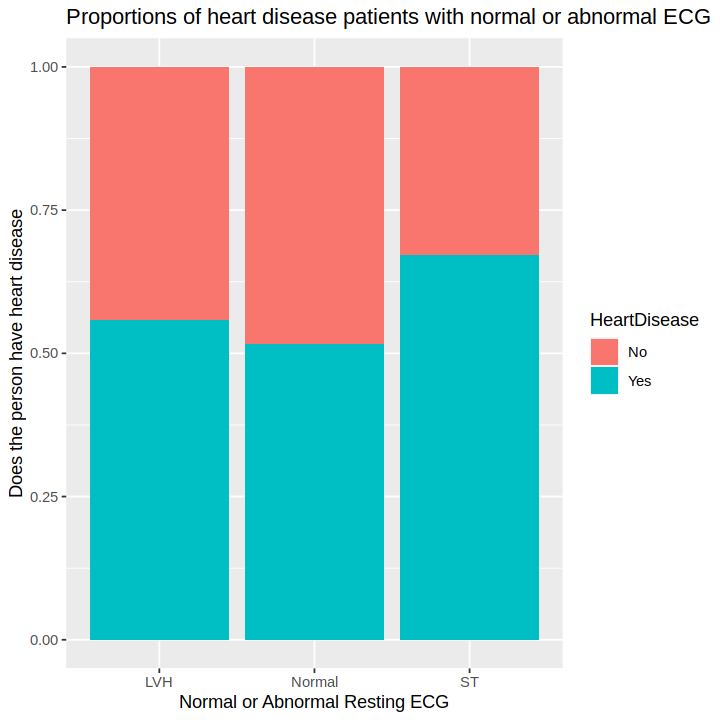

In [11]:
options(repr.plot.width = 6, repr.plot.height = 6)
Resting_ECG_plot<-heart_disease_train|>
ggplot(aes(x=RestingECG, fill=HeartDisease))+
geom_bar(position="fill")+
xlab("Normal or Abnormal Resting ECG")+
ylab("Does the person have heart disease")+
labs("Heart Disease")+
ggtitle("Proportions of heart disease patients with normal or abnormal ECG")
Resting_ECG_plot

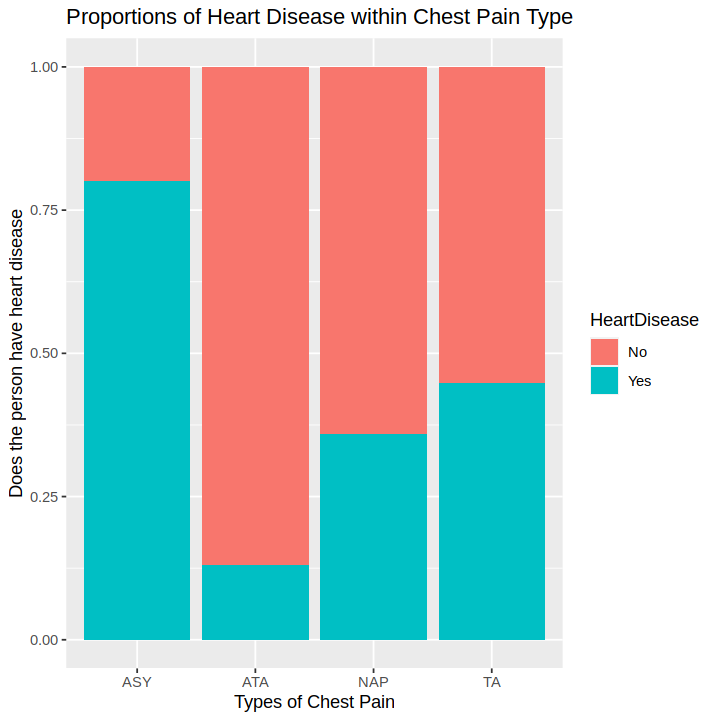

In [12]:
options(repr.plot.width = 6, repr.plot.height = 6)
Chest_pain_type_plot<-heart_disease_train|>
ggplot(aes(x=ChestPainType, fill=HeartDisease))+
geom_bar(position="fill")+
xlab("Types of Chest Pain")+
ylab("Does the person have heart disease")+
labs("Heart Disease")+
ggtitle("Proportions of Heart Disease within Chest Pain Type")
Chest_pain_type_plot

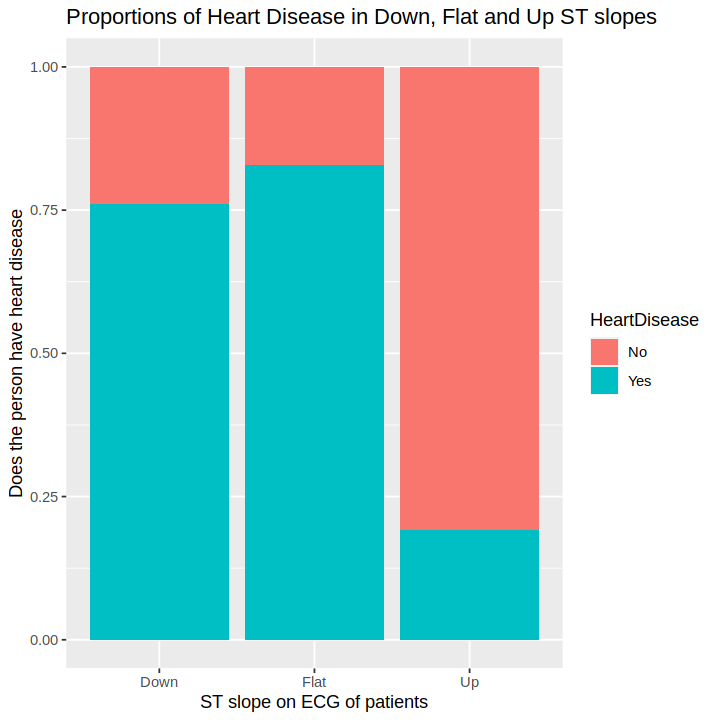

In [13]:
options(repr.plot.width = 6, repr.plot.height = 6)
ST_Slope_plot<-heart_disease_train|>
ggplot(aes(x=ST_Slope, fill=HeartDisease))+
geom_bar(position="fill")+
xlab("ST slope on ECG of patients")+
ylab("Does the person have heart disease")+
labs("Heart Disease")+
ggtitle("Proportions of Heart Disease in Down, Flat and Up ST slopes")
ST_Slope_plot

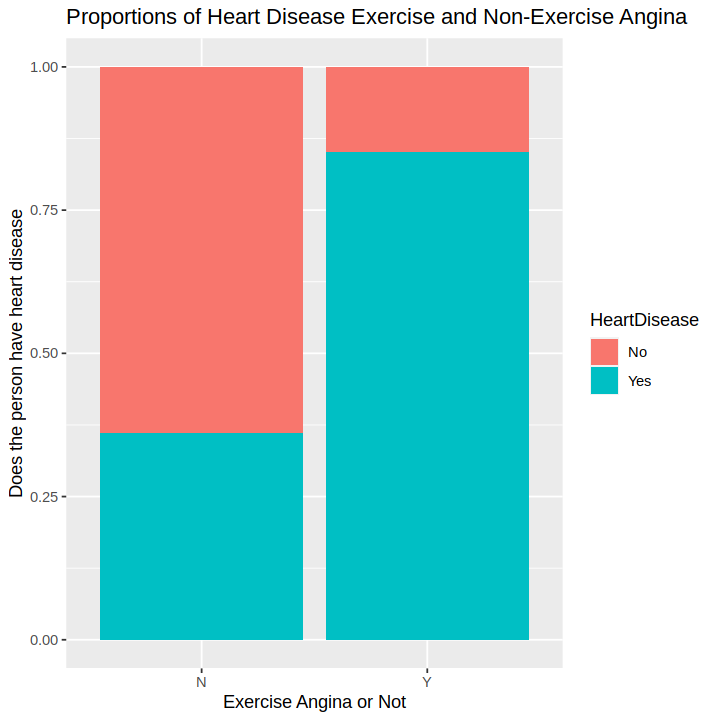

In [14]:
options(repr.plot.width = 6, repr.plot.height = 6)
Exercise_Angina_plot<-heart_disease_train|>
ggplot(aes(x=ExerciseAngina, fill=HeartDisease))+
geom_bar(position="fill")+
xlab("Exercise Angina or Not")+
ylab("Does the person have heart disease")+
labs("Heart Disease")+
ggtitle("Proportions of Heart Disease Exercise and Non-Exercise Angina")
Exercise_Angina_plot

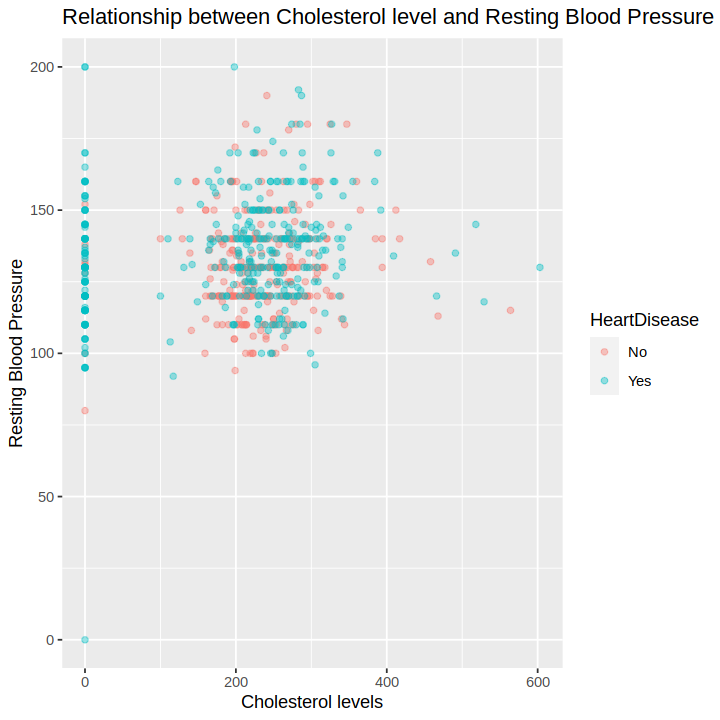

In [15]:
options(repr.plot.width = 6, repr.plot.height = 6)
Cholesterol_bloodpressure_plot<-heart_disease_train|>
ggplot(aes(x=Cholesterol, y=RestingBP))+
geom_point(aes(color=HeartDisease),alpha=0.4)+
xlab("Cholesterol levels")+
ylab("Resting Blood Pressure")+
labs("Heart Disease")+ 
ggtitle("Relationship between Cholesterol level and Resting Blood Pressure")
Cholesterol_bloodpressure_plot


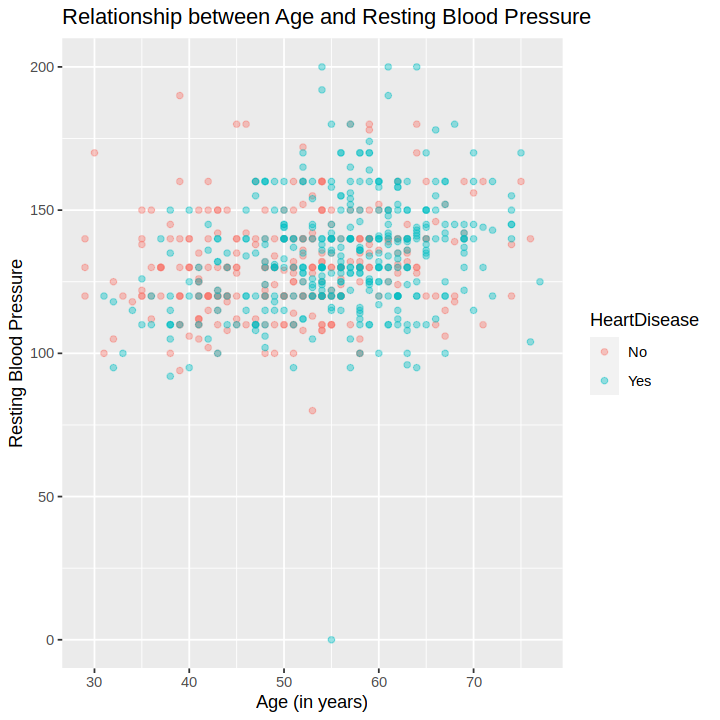

In [16]:
options(repr.plot.width = 6, repr.plot.height = 6)
Age_RestingBP_plot<-heart_disease_train|>
ggplot(aes(x=Age, y=RestingBP))+
geom_point(aes(color=HeartDisease),alpha=0.4)+
xlab("Age (in years)")+
ylab("Resting Blood Pressure")+
labs("Heart Disease")+
ggtitle("Relationship between Age and Resting Blood Pressure")
Age_RestingBP_plot

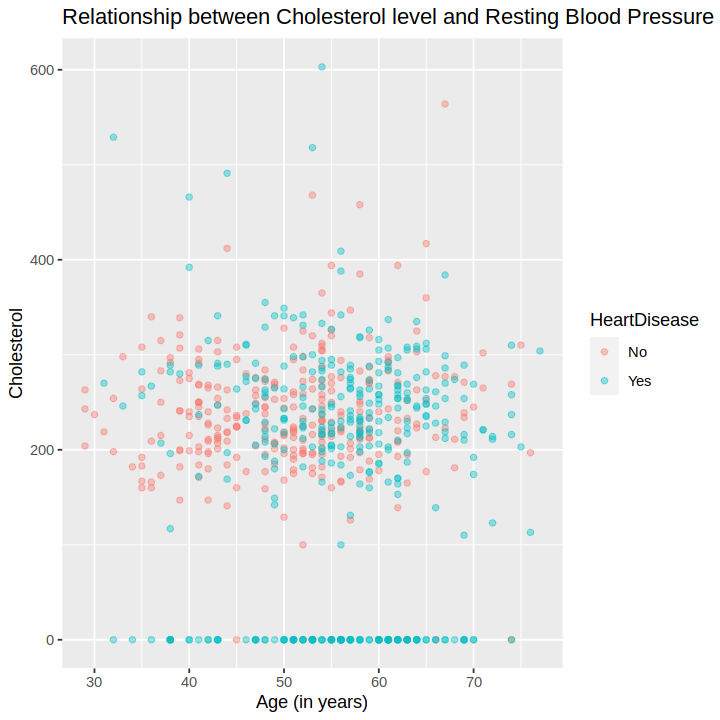

In [17]:
options(repr.plot.width = 6, repr.plot.height = 6)
Age_Cholesterol_plot<-heart_disease_train|>
ggplot(aes(x=Age, y=Cholesterol))+
geom_point(aes(color=HeartDisease),alpha=0.4)+
xlab("Age (in years)")+
ylab("Cholesterol")+
labs("Heart Disease")+
ggtitle("Relationship between Cholesterol level and Resting Blood Pressure")
Age_Cholesterol_plot

Scatterplots dont show a significant relationship which is a good sign......

scaling data-

In [18]:
train_data_scaled <- as.data.frame(scale(heart_disease_train[, c("Age", "MaxHR")]))
colnames(train_data_scaled) <- c("scaled_Age", "scaled_MaxHR")
heart_combined <- cbind(heart_disease_train, train_data_scaled)
heart_scaled <- select(heart_combined, HeartDisease , scaled_Age , scaled_MaxHR)

heart_scaled_slice<-heart_scaled|>
    slice(1:5) 
heart_scaled_slice

HeartDisease scaled_Age  scaled_MaxHR
1 No           -1.77725542 -1.541251706
2 No           -1.56452895  1.318953011
3 No            0.03091954  0.206651177
4 No           -0.60725985 -0.667300265
5 No           -1.24543925  0.008025849

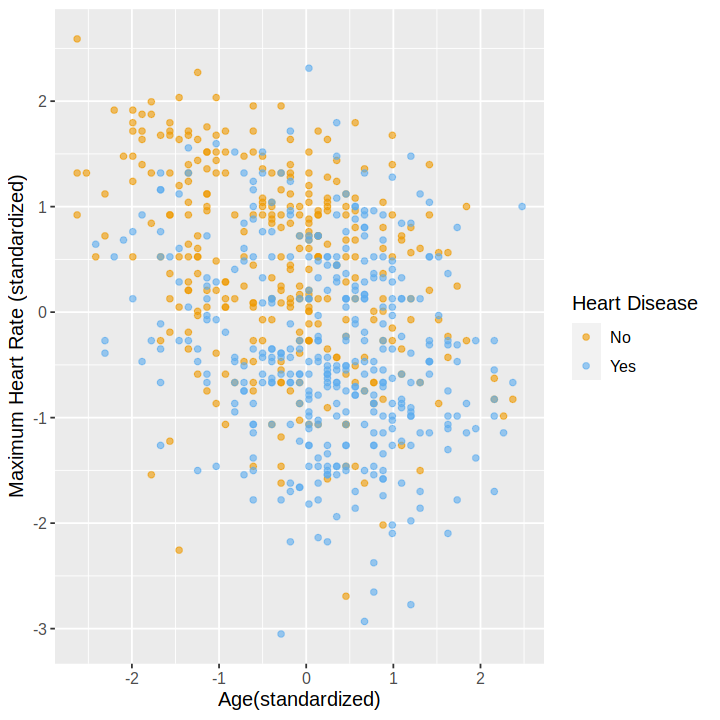

In [19]:
age_maxHR <- heart_scaled |>
  ggplot(aes(x = scaled_Age, y = scaled_MaxHR, color = HeartDisease)) +
  geom_point(alpha = 0.6) +
  labs(x = "Age(standardized)", 
       y = "Maximum Heart Rate (standardized)",
       color = "Heart Disease") +
  scale_color_manual(values = c("orange2", "steelblue2")) +
  theme(text = element_text(size = 12))
age_maxHR

In [46]:
heart_data<-read_csv(url)|>
    mutate(HeartDisease=as_factor(HeartDisease))|>
    rename(ST_depression=Oldpeak)|>

    select(-FastingBS)

heart_disease_slice<-heart_data|>
slice(1:5)
heart_disease_slice

set.seed(1234)
heart_disease_split <- initial_split(heart_data, prop = 0.75, strata = HeartDisease)
heart_disease_train <- training(heart_disease_split)
heart_disease_test <- testing(heart_disease_split)

heart_disease_slice_train<-heart_disease_train |>
slice(1:5)
heart_disease_slice_train

Rows: 918 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Sex, ChestPainType, RestingECG, ExerciseAngina, ST_Slope
dbl (7): Age, RestingBP, Cholesterol, FastingBS, MaxHR, Oldpeak, HeartDisease

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Age Sex ChestPainType RestingBP Cholesterol RestingECG MaxHR ExerciseAngina
1 40  M   ATA           140       289         Normal     172   N             
2 49  F   NAP           160       180         Normal     156   N             
3 37  M   ATA           130       283         ST          98   N             
4 48  F   ASY           138       214         Normal     108   Y             
5 54  M   NAP           150       195         Normal     122   N             
  ST_depression ST_Slope HeartDisease
1 0.0           Up       0           
2 1.0           Flat     1           
3 0.0           Up       0           
4 1.5           Flat     1           
5 0.0           Up       0

Age Sex ChestPainType RestingBP Cholesterol RestingECG MaxHR ExerciseAngina
1 37  M   ATA           130       283         ST          98   N             
2 39  M   NAP           120       339         Normal     170   N             
3 54  M   ATA           110       208         Normal     142   N             
4 48  F   ATA           120       284         Normal     120   N             
5 42  F   NAP           115       211         ST         137   N             
  ST_depression ST_Slope HeartDisease
1 0             Up       0           
2 0             Up       0           
3 0             Up       0           
4 0             Up       0           
5 0             Up       0

Below, I set up a 5-fold cross-validation framework using the tidymodels package in R for predicting heart disease. For data preprocessing, I created a recipe that includes MaxHR and Age as predictor variables, scaling and centering all predictors. The model specification involves a k-nearest neighbors (k-NN) approach with rectangular weighting and a tuning parameter for the number of neighbors. I established a grid of odd values from 1 to 100 for the number of neighbors. By constructing a workflow, I integrated the preprocessing recipe, k-NN model, and conducted a grid search for hyperparameter tuning using cross-validation. The resulting accuracy metrics for different numbers of neighbors were then extracted for further analysis.

In [39]:
heart_disease_vfold <- vfold_cv(heart_disease_train, v = 5, strata = HeartDisease)

heart_disease_recipe <- recipe(HeartDisease ~MaxHR, Age,
                        data = heart_disease_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

heart_disease_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 2))

heart_disease_results <- workflow() |>
  add_recipe(heart_disease_recipe) |>
  add_model(heart_disease_spec) |>
  tune_grid(resamples = heart_disease_vfold, grid = k_vals) |>
  collect_metrics() 

accuracies <- heart_disease_results |>
  filter(.metric == "accuracy")

accuracies_slice<-accuracies|>
slice(1:5)
accuracies_slice

neighbors .metric  .estimator mean      n std_err    .config              
1 1         accuracy binary     0.5246069 5 0.01826730 Preprocessor1_Model01
2 3         accuracy binary     0.5712387 5 0.02976276 Preprocessor1_Model02
3 5         accuracy binary     0.5711441 5 0.02006953 Preprocessor1_Model03
4 7         accuracy binary     0.6002250 5 0.01614092 Preprocessor1_Model04
5 9         accuracy binary     0.6234775 5 0.01348600 Preprocessor1_Model05

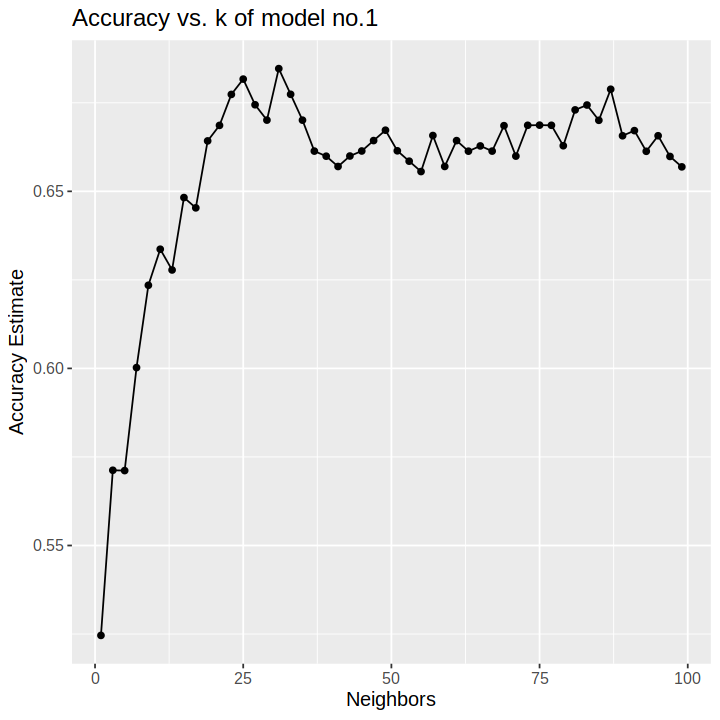

In [40]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))+
ggtitle("Accuracy vs. k of model no.1")

accuracy_vs_k

options(repr.plot.width = 6, repr.plot.height = 6)

 This plot provides a clear depiction of how the model's accuracy varies with different numbers of neighbors, aiding in the selection of an optimal k value for the k-NN model in predicting heart disease. We can see that the k value that provides the highest accuracy is 31.

In [41]:
heart_tuned_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = 31) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_tuned_fit <- workflow() |>
  add_recipe(heart_disease_recipe) |>
  add_model(heart_tuned_spec) |>
  fit(data = heart_disease_train)

I fine-tuned the k-NN classification model, setting the optimal k value to 31.

In [42]:
heart_disease_prediction<-predict(heart_tuned_fit, heart_disease_test)|>
bind_cols(heart_disease_test)

In [43]:
heart_disease_metrics<-heart_disease_prediction|>
metrics(truth=HeartDisease, estimate=.pred_class)
heart_disease_metrics

.metric  .estimator .estimate
1 accuracy binary     0.6869565
2 kap      binary     0.3670209

In [44]:
heart_conf_mat<-heart_disease_prediction|>
conf_mat(truth=HeartDisease, estimate=.pred_class)
heart_conf_mat

          Truth
Prediction  0  1
         0 67 36
         1 36 91

The confusion matrix indicates that out of a total of 230 predictions, the model correctly identified 67 instances with no heart disease and 91 instances with heart disease. However, it misclassified 36 instances as having heart disease when they did not, and 36 instances as not having heart disease when they did. 

In [77]:
model_1_recall<-91/(91+36)
recall

[1] 0.7165354

I want to investigate whether the model would work better with one sex than the other, so I repeated the above model building steps with the male and female data separately.

In [47]:
heart_male_data<-heart_data|>
filter(Sex=="M")


heart_male_data_slice<-heart_male_data|>
slice(1:5)
heart_male_data_slice

Age Sex ChestPainType RestingBP Cholesterol RestingECG MaxHR ExerciseAngina
1 40  M   ATA           140       289         Normal     172   N             
2 37  M   ATA           130       283         ST          98   N             
3 54  M   NAP           150       195         Normal     122   N             
4 39  M   NAP           120       339         Normal     170   N             
5 54  M   ATA           110       208         Normal     142   N             
  ST_depression ST_Slope HeartDisease
1 0             Up       0           
2 0             Up       0           
3 0             Up       0           
4 0             Up       0           
5 0             Up       0

In [48]:
set.seed(1234)
heart_male_split <- initial_split(heart_male_data, prop = 0.75, strata = HeartDisease)
heart_male_train <- training(heart_male_split)
heart_male_test <- testing(heart_male_split)

heart_male_slice_train<-heart_male_train |>
slice(1:5)
heart_male_slice_train

Age Sex ChestPainType RestingBP Cholesterol RestingECG MaxHR ExerciseAngina
1 37  M   ATA           130       283         ST          98   N             
2 39  M   NAP           120       339         Normal     170   N             
3 39  M   ATA           120       204         Normal     145   N             
4 44  M   ATA           120       184         Normal     142   N             
5 40  M   NAP           130       215         Normal     138   N             
  ST_depression ST_Slope HeartDisease
1 0             Up       0           
2 0             Up       0           
3 0             Up       0           
4 1             Flat     0           
5 0             Up       0

In [49]:
heart_male_vfold <- vfold_cv(heart_male_train, v = 5, strata = HeartDisease)

heart_male_recipe <- recipe(HeartDisease ~MaxHR, Age,
                        data = heart_male_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

heart_male_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

k_male_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 2))

heart_male_results <- workflow() |>
  add_recipe(heart_male_recipe) |>
  add_model(heart_male_spec) |>
  tune_grid(resamples = heart_male_vfold, grid = k_male_vals) |>
  collect_metrics() 

accuracies_male <- heart_male_results |>
  filter(.metric == "accuracy")


In [50]:
accuracies_male_slice<-accuracies_male|>
slice(1:5)
accuracies_male_slice

neighbors .metric  .estimator mean      n std_err    .config              
1 1         accuracy binary     0.5415053 5 0.01881421 Preprocessor1_Model01
2 3         accuracy binary     0.5710160 5 0.02660964 Preprocessor1_Model02
3 5         accuracy binary     0.6169725 5 0.02136573 Preprocessor1_Model03
4 7         accuracy binary     0.6446823 5 0.02725269 Preprocessor1_Model04
5 9         accuracy binary     0.6501869 5 0.02687123 Preprocessor1_Model05

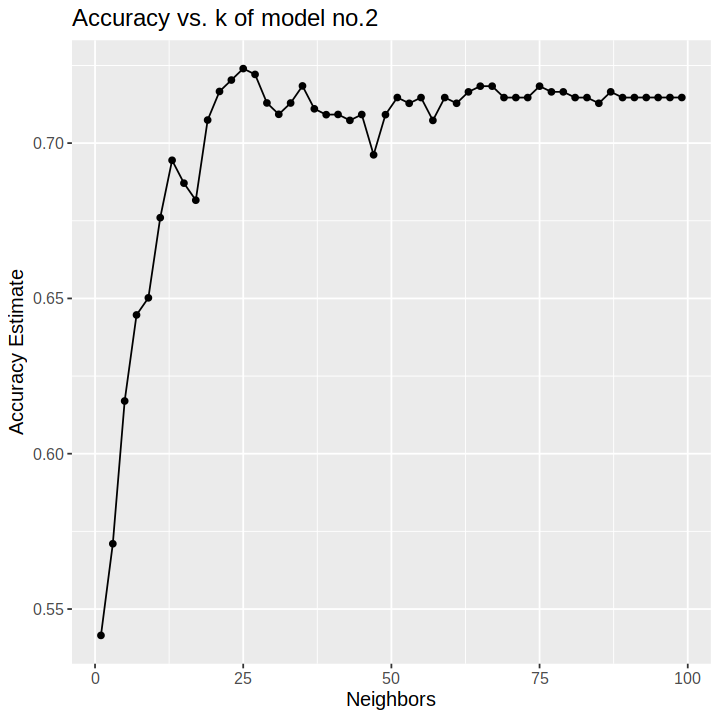

In [51]:
accuracy_vs_k_male <- ggplot(accuracies_male, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))+
ggtitle("Accuracy vs. k of model no.2")
accuracy_vs_k_male

options(repr.plot.width = 6, repr.plot.height = 5)

In [52]:
heart_male_tuned_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = 25) |>
  set_engine("kknn") |>
  set_mode("classification")

heart__male_tuned_fit <- workflow() |>
  add_recipe(heart_male_recipe) |>
  add_model(heart_male_tuned_spec) |>
  fit(data = heart_male_train)

In [53]:
heart_male_prediction<-predict(heart__male_tuned_fit, heart_male_test)|>
bind_cols(heart_male_test)

heart_male_prediction_slice<-heart_male_prediction|>
slice(1:5)
heart_male_prediction_slice

.pred_class Age Sex ChestPainType RestingBP Cholesterol RestingECG MaxHR
1 0           40  M   ATA           140       289         Normal     172  
2 1           54  M   NAP           150       195         Normal     122  
3 0           54  M   ATA           110       208         Normal     142  
4 1           49  M   ASY           140       234         Normal     140  
5 1           60  M   ASY           100       248         Normal     125  
  ExerciseAngina ST_depression ST_Slope HeartDisease
1 N              0             Up       0           
2 N              0             Up       0           
3 N              0             Up       0           
4 Y              1             Flat     1           
5 N              1             Flat     1

In [54]:
heart_male_metrics<-heart_male_prediction|>
metrics(truth=HeartDisease, estimate=.pred_class)
heart_male_metrics

.metric  .estimator .estimate
1 accuracy binary     0.6813187
2 kap      binary     0.2883915

The accuracy is slightly better than both combined; however, the kap is lower, which means that the agreement between predictions and actual outcomes is not significantly better than what could occur by chance.

In [55]:
heart_female_data<-heart_data|>
filter(Sex=="F")


heart_female_data_slice<-heart_female_data|>
slice(1:5)
heart_female_data_slice

Age Sex ChestPainType RestingBP Cholesterol RestingECG MaxHR ExerciseAngina
1 49  F   NAP           160       180         Normal     156   N             
2 48  F   ASY           138       214         Normal     108   Y             
3 45  F   ATA           130       237         Normal     170   N             
4 48  F   ATA           120       284         Normal     120   N             
5 37  F   NAP           130       211         Normal     142   N             
  ST_depression ST_Slope HeartDisease
1 1.0           Flat     1           
2 1.5           Flat     1           
3 0.0           Up       0           
4 0.0           Up       0           
5 0.0           Up       0

In [56]:
set.seed(1234)
heart_female_split <- initial_split(heart_female_data, prop = 0.75, strata = HeartDisease)
heart_female_train <- training(heart_female_split)
heart_female_test <- testing(heart_female_split)

heart_female_slice_train<-heart_female_train |>
slice(1:5)
heart_female_slice_train

Age Sex ChestPainType RestingBP Cholesterol RestingECG MaxHR ExerciseAngina
1 45  F   ATA           130       237         Normal     170   N             
2 48  F   ATA           120       284         Normal     120   N             
3 37  F   NAP           130       211         Normal     142   N             
4 42  F   NAP           115       211         ST         137   N             
5 54  F   ATA           120       273         Normal     150   N             
  ST_depression ST_Slope HeartDisease
1 0.0           Up       0           
2 0.0           Up       0           
3 0.0           Up       0           
4 0.0           Up       0           
5 1.5           Flat     0

In [57]:
heart_male_vfold <- vfold_cv(heart_female_train, v = 5, strata = HeartDisease)

heart_female_recipe <- recipe(HeartDisease ~MaxHR, Age,
                        data = heart_female_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

heart_female_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

k_female_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 2))

heart_female_results <- workflow() |>
  add_recipe(heart_female_recipe) |>
  add_model(heart_female_spec) |>
  tune_grid(resamples = heart_male_vfold, grid = k_female_vals) |>
  collect_metrics() 

accuracies_female <- heart_female_results |>
  filter(.metric == "accuracy")


In [58]:
accuracies_female_slice<-accuracies_female|>
slice(1:5)
accuracies_female_slice

neighbors .metric  .estimator mean      n std_err    .config              
1 1         accuracy binary     0.6676190 5 0.01544135 Preprocessor1_Model01
2 3         accuracy binary     0.6757143 5 0.04179504 Preprocessor1_Model02
3 5         accuracy binary     0.7228571 5 0.02879476 Preprocessor1_Model03
4 7         accuracy binary     0.7157143 5 0.01795371 Preprocessor1_Model04
5 9         accuracy binary     0.7433333 5 0.01200907 Preprocessor1_Model05

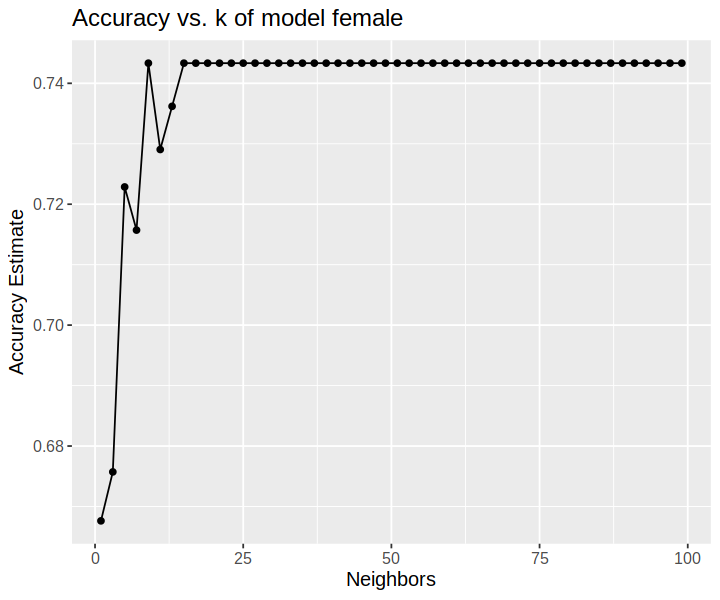

In [59]:
accuracy_vs_k_female <- ggplot(accuracies_female, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))+
ggtitle("Accuracy vs. k of model female")
accuracy_vs_k_female

options(repr.plot.width = 6, repr.plot.height = 5)

In [60]:
heart_female_tuned_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = 25) |>
  set_engine("kknn") |>
  set_mode("classification")

heart__female_tuned_fit <- workflow() |>
  add_recipe(heart_female_recipe) |>
  add_model(heart_female_tuned_spec) |>
  fit(data = heart_female_train)

In [61]:
heart_female_prediction<-predict(heart__female_tuned_fit, heart_female_test)|>
bind_cols(heart_female_test)

heart_female_prediction_slice<-heart_female_prediction|>
slice(1:5)
heart_female_prediction_slice

.pred_class Age Sex ChestPainType RestingBP Cholesterol RestingECG MaxHR
1 0           49  F   NAP           160       180         Normal     156  
2 0           43  F   TA            100       223         Normal     142  
3 0           48  F   ATA           120       177         ST         148  
4 0           47  F   ASY           120       205         Normal      98  
5 0           41  F   ATA           130       245         Normal     150  
  ExerciseAngina ST_depression ST_Slope HeartDisease
1 N              1             Flat     1           
2 N              0             Up       0           
3 N              0             Up       0           
4 Y              2             Flat     1           
5 N              0             Up       0

In [62]:
heart_female_metrics<-heart_female_prediction|>
metrics(truth=HeartDisease, estimate=.pred_class)
heart_female_metrics

.metric  .estimator .estimate
1 accuracy binary     0.7346939
2 kap      binary     0.0000000

The accuracy for the female model is even higher than the male model, but the kap is 0. This means the agreement between predictions and actual outcomes is basically the same as a random guess. For this reason, I will carry on improving the model using the male data. 

Other than the models I showed here, I tested how filtering out different categories affect the accuracy. I found out that if I use groups that are at a high risk of having heart diseases, like males with chest pain type of AYP, I would get an accuracy of 95%, but the kap would be 0. This might be due to the imbalance in the data, there are a lot more "yes" than "no" in males with chest pain type of AYP. 

There are variables that play a role in the prediction of heart disease like Resting ECG (Centre (UK)), but we cannot incorporate that into our model because it is a categorical datatype. Therefore, I chose male data with "Normal" ECG level, which does not have significant imbalance shown in figure__.

In [63]:
heart_good_data<-heart_male_data|>
filter(RestingECG=="Normal")

heart_good_data_slice<-heart_good_data|>
slice(1:5)
heart_good_data_slice

Age Sex ChestPainType RestingBP Cholesterol RestingECG MaxHR ExerciseAngina
1 40  M   ATA           140       289         Normal     172   N             
2 54  M   NAP           150       195         Normal     122   N             
3 39  M   NAP           120       339         Normal     170   N             
4 54  M   ATA           110       208         Normal     142   N             
5 37  M   ASY           140       207         Normal     130   Y             
  ST_depression ST_Slope HeartDisease
1 0.0           Up       0           
2 0.0           Up       0           
3 0.0           Up       0           
4 0.0           Up       0           
5 1.5           Flat     1

In [64]:
set.seed(1234)
heart_good_split <- initial_split(heart_good_data, prop = 0.75, strata = HeartDisease)
heart_good_train <- training(heart_good_split)
heart_good_test <- testing(heart_good_split)

heart_good_slice_train<-heart_good_train |>
slice(1:5)
heart_good_slice_train

Age Sex ChestPainType RestingBP Cholesterol RestingECG MaxHR ExerciseAngina
1 54  M   NAP           150       195         Normal     122   N             
2 39  M   NAP           120       339         Normal     170   N             
3 54  M   ATA           110       208         Normal     142   N             
4 44  M   ATA           120       184         Normal     142   N             
5 36  M   NAP           130       209         Normal     178   N             
  ST_depression ST_Slope HeartDisease
1 0             Up       0           
2 0             Up       0           
3 0             Up       0           
4 1             Flat     0           
5 0             Up       0

In [67]:
heart_good_vfold <- vfold_cv(heart_good_train, v = 5, strata = HeartDisease)

heart_good_recipe <- recipe(HeartDisease ~MaxHR, Age,
                        data = heart_good_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

heart_good_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

k_good_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 2))

heart_good_results <- workflow() |>
  add_recipe(heart_good_recipe) |>
  add_model(heart_good_spec) |>
  tune_grid(resamples = heart_good_vfold, grid = k_good_vals) |>
  collect_metrics() 


In [69]:

accuracies_good <- heart_good_results |>
  filter(.metric == "accuracy")

accuracies_good_slice<-accuracies_good|>
slice(1:5)
accuracies_good_slice


neighbors .metric  .estimator mean      n std_err     .config              
1 1         accuracy binary     0.5605303 5 0.039195011 Preprocessor1_Model01
2 3         accuracy binary     0.5881352 5 0.020080748 Preprocessor1_Model02
3 5         accuracy binary     0.6373266 5 0.017672877 Preprocessor1_Model03
4 7         accuracy binary     0.6614263 5 0.010464847 Preprocessor1_Model04
5 9         accuracy binary     0.6830157 5 0.006557566 Preprocessor1_Model05

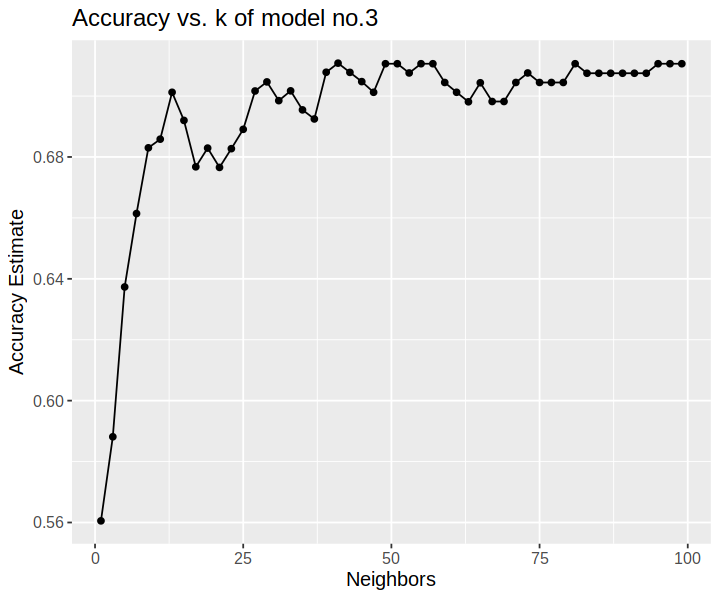

In [70]:
accuracy_vs_k_good <- ggplot(accuracies_good, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))+
ggtitle("Accuracy vs. k of model no.3")

accuracy_vs_k_good

In [71]:
heart_good_tuned_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = 97) |>
  set_engine("kknn") |>
  set_mode("classification")

heart__good_tuned_fit <- workflow() |>
  add_recipe(heart_good_recipe) |>
  add_model(heart_good_tuned_spec) |>
  fit(data = heart_good_train)

In [72]:
heart_good_prediction<-predict(heart__good_tuned_fit, heart_good_test)|>
bind_cols(heart_good_test)

heart_good_prediction_slice<-heart_good_prediction|>
slice(1:5)
heart_good_prediction_slice

.pred_class Age Sex ChestPainType RestingBP Cholesterol RestingECG MaxHR
1 0           40  M   ATA           140       289         Normal     172  
2 1           37  M   ASY           140       207         Normal     130  
3 0           39  M   ATA           120       204         Normal     145  
4 0           38  M   ASY           110       196         Normal     166  
5 1           40  M   NAP           130       215         Normal     138  
  ExerciseAngina ST_depression ST_Slope HeartDisease
1 N              0.0           Up       0           
2 Y              1.5           Flat     1           
3 N              0.0           Up       0           
4 N              0.0           Flat     1           
5 N              0.0           Up       0

In [73]:
heart_good_metrics<-heart_good_prediction|>
metrics(truth=HeartDisease, estimate=.pred_class)
heart_good_metrics

.metric  .estimator .estimate
1 accuracy binary     0.6972477
2 kap      binary     0.3607606

In [74]:
good_conf_mat<-heart_good_prediction|>
conf_mat(truth=HeartDisease, estimate=.pred_class)
good_conf_mat

          Truth
Prediction  0  1
         0 25 13
         1 20 51

In [78]:
final_model_recall<-51/(51+13)
final_model_recall

[1] 0.796875

From here, we see that both the the accuracy and kap is better than model 1 and 2. The recall is also higher, with ~0.72 in model 1 and ~0.80 in model 4, which is good because we don't want our model to wrongly predict individuals with heart disease as not having the condition.

In [ ]:
# create the grid of area/smoothness vals, and arrange in a data frame
are_grid <- seq(min(unscaled_cancer$Area), 
                max(unscaled_cancer$Area), 
                length.out = 100)
smo_grid <- seq(min(unscaled_cancer$Smoothness), 
                max(unscaled_cancer$Smoothness), 
                length.out = 100)
asgrid <- as_tibble(expand.grid(Area = are_grid, 
                                Smoothness = smo_grid))

# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(knn_fit, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) |> 
  rename(Class = .pred_class)

# plot:
# 1. the colored scatter of the original data
# 2. the faded colored scatter for the grid points
wkflw_plot <-
  ggplot() +
  geom_point(data = unscaled_cancer, 
             mapping = aes(x = Area, 
                           y = Smoothness, 
                           color = Class), 
             alpha = 0.75) +
  geom_point(data = prediction_table, 
             mapping = aes(x = Area, 
                           y = Smoothness, 
                           color = Class), 
             alpha = 0.02, 
             size = 5) +
  labs(color = "Diagnosis", 
       x = "Area", 
       y = "Smoothness") +
  scale_color_manual(values = c("orange2", "steelblue2")) +
  theme(text = element_text(size = 12))

wkflw_plot

<font size="5">Expected Outcomes and Significance<font size="4">
    
**Expected Findings:**
    We anticipate a predictive model that offers accurate insights into heart disease likelihood taking into consideration our predictor variables. Our code will be able to predict whether heart failure is "yes" or "no" depending on the trends observed between our predictor variables and heart disease results.

**Significance:** 
    The model's findings can significantly impact public health by enabling early detection, potentially saving lives and reducing healthcare costs.
    
**Future Questions:**
    This project may lead to further research on model refinement, additional predictors, or personalized risk assessment for heart disease to further improve accuracy of prediction.


<font size="5">Reference<font size="4">
    
Centre (UK), National Guideline. Resting Electrocardiography. Www.ncbi.nlm.nih.gov, National Institute for Health and Care Excellence (NICE), 1 Apr. 2016, www.ncbi.nlm.nih.gov/books/NBK367910/#:~:text=Resting%2012%2Dlead%20electrocardiography%20(ECG.